# Plot code
This notebook contains the plotting Code to generate the final plots within the frame of a bachelor thesis: ["Timing distributions of sequence elements for dendritic sequence processing"](https://github.com/goody139/bachelor-thesis)

<small> June 2024 <br>
University Osnabrück <br>
Cognitive Science <br>
Lisa Golla <small>

In [1]:
using Plots, StatsPlots, ROCAnalysis, Serialization, Measures

#### Basic Functions

In [2]:
function gaussian(; args::NamedTuple)
    # negative values are truncated
    value = rand(Normal(args.mean, args.sd))
    return value > 0 ? value : gaussian(args=(mean=args.mean, sd=args.sd))
end
 
function uniform(; args::NamedTuple )
    return rand(Uniform(args.bound_start,args.bound_end))
end

uniform (generic function with 1 method)

In [3]:
function load_performances(;experiment_name=nothing, file_path)
    variables_dict = open(file_path, "r") do file
        deserialize(file)
    end
    return isnothing(experiment_name) ? variables_dict : variables_dict[experiment_name]
end  

load_performances (generic function with 1 method)

#### Evaluation Metrics

In [4]:
const contingency = Vector{Tuple{Float64,Int64, Int64,Int64, Int64}}

Vector{Tuple{Float64, Vararg{Int64, 4}}} (alias for Array{Tuple{Float64, Vararg{Int64, 4}}, 1})

In [5]:
function accuracy(performance::contingency, trialcount::Int64)
    accuracy = Float64[]
    tau = Float64[]
    for table in performance
        acc = ((table[4] + table[5]) / trialcount ) * 100.0
        push!(accuracy, acc )
        push!(tau, table[1])
    end
    return tau, accuracy
end

function f_score(performance::contingency)
    score = Float64[]
    tau = Float64[]
    for table in performance
        fscore = ((table[4]) / (table[4] + ((table[2] + table[3]) * 0.5)) ) * 100.0
        push!(score, fscore )
        push!(tau, table[1])
    end
    return tau, score
end

function sensitivity(performance::contingency)
    sensitivities = Float64[]
    tau = Float64[]
    for table in performance
        sens = ((table[4]) / (table[4] + table[3]) ) * 100.0
        push!(sensitivities, sens )
        push!(tau, table[1])
    end
    return tau, sensitivities
end

function specificity(performance::contingency)
    specificities = Float64[]
    tau = Float64[]
    for table in performance
        spec = ((table[5]) / (table[5] + table[2]) ) * 100.0
        push!(specificities, spec )
        push!(tau, table[1])
    end
    return tau, specificities
end

function TPR_FPR(performance::contingency)
    TP_rate = Float64[]
    FP_rate = Float64[]
    for table in performance
        push!(TP_rate, (table[4] / (table[4] + table[3])) * 100 )
        push!(FP_rate, (table[2] / (table[2] + table[5])) * 100)
    end
    return FP_rate,TP_rate
end

function balanced_accuracy(performance::contingency)
    balanced_accuracies = Float64[]
    tau = Float64[]
    for table in performance 
        sensitivity = table[4] / (table[4] + table[3]) * 100.0
        specificity = table[5] / (table[5] + table[2]) * 100.0
        balanced_accuracy = (sensitivity + specificity) / 2
        push!(balanced_accuracies, balanced_accuracy)
        push!(tau, table[1])
    end 
    return tau, balanced_accuracies
end

function matthews_correlation(performance::contingency)
    correlations = Float64[]
    tau = Float64[]
    for table in performance 
        fp, fn, tp, tn = table[2], table[3], table[4], table[5]
        numerator = tp * tn - fp * fn
        denominator = sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = (numerator / denominator) * 100
        push!(correlations, mcc)
        push!(tau, table[1])
    end 
    return tau, correlations
end

matthews_correlation (generic function with 1 method)

### Plotting Code

In [6]:
function draw_special(performances,distribution; legend=false, balanced=true)
    performance = performances[2]
    distargs = performances[1]
    tau , score = f_score(performance)
    _ , sensitivities = sensitivity(performance)
    _ , specificities = specificity(performance)
    _ , acc = accuracy(performance,Int(sum(performance[1])-20))
    _ , correlations = matthews_correlation(performance)
    _ , balanced_acc = balanced_accuracy(performance)
    plot_title= ""
    
    if legend == true 
        plot(tau , score; title= plot_title, label = " F1-Score ",lw=3,titlefontsize=15)
        plot!(tau , acc; title= plot_title, label = " Accuracy ",lw=3,titlefontsize=15)
        plot!(tau , sensitivities; title= plot_title, label = " Sensitivities ",lw=2, linestyle=:dash,titlefontsize=15)
        plot!(tau , specificities; title= plot_title, label = " Specificity ",lw=2,linestyle=:dash,titlefontsize=15)
        plot!(tau , correlations; title= plot_title, label = " MCC ",lw=2,linestyle=:dash,titlefontsize=13)
        if balanced == false
            plot!(tau , balanced_acc; title= plot_title, label=" Balanced Accuracy ", lw=2,linestyle=:dash,titlefontsize=15)
        end 
        plot!([] , []; title= plot_title, label=" Balanced Accuracy ", lw=2,linestyle=:dash,titlefontsize=15)
        plot!(legend=:bottom ,legendfontsize=14)
    else
        plot(tau , score; title= plot_title,lw=3,titlefontsize=15)
        plot!(tau , acc; title= plot_title,lw=3,titlefontsize=15)
        plot!(tau , sensitivities; title= plot_title,lw=2, linestyle=:dash,titlefontsize=15)
        plot!(tau , specificities; title= plot_title,lw=2,linestyle=:dash,titlefontsize=15)
        plot!(tau , correlations; title= plot_title,lw=2,linestyle=:dash,titlefontsize=13)
        if balanced == false
            plot!(tau , balanced_acc; title= plot_title,lw=2,linestyle=:dash,titlefontsize=15)
        end 
        plot!(legend=:false)
        plot!(ytickfontsize = 15)
        plot!(xtickfontsize = 15)
    end 

    plot!(ylims = (0,100))
    plot!(xlabelfontsize=15, ytickfontsize = 15)
    plot!(ylabelfontsize=15, xtickfontsize = 15)
    ylabel!("\n Performance (%)")
    xlabel!(" Plateau Length (ms) \n")

end

draw_special (generic function with 1 method)

In [7]:
function draw_roc_special(performances, p2, p3, distribution)
    performance = performances[2]
    distargs = performances[1]
    tau, _ = f_score(performance)
    FPR, TPR = TPR_FPR(performance)
    r = roc(TPR, FPR)
    AUC_score = round.(AUC(r), digits=4)

    performance = p2[2]
    FPR2, TPR2 = TPR_FPR(performance)
    r2 = roc(TPR2, FPR2)
    AUC_score2 = round.(AUC(r2), digits=4)

    performance = p3[2]
    FPR3, TPR3 = TPR_FPR(performance)
    r3 = roc(TPR3, FPR3)
    AUC_score3 = round.(AUC(r3), digits=4)

    plot_title=""
    
    plot(FPR , TPR; title= plot_title, label = " balanced, AUC: $AUC_score ",lw=3, color=:lightsalmon, titlefontsize=7)
    plot!(FPR2 , TPR2; title= plot_title, label = " unbalanced, AUC: $AUC_score2 ",lw=3,titlefontsize=7)
    plot!(FPR3 , TPR3; title= plot_title, label = " extra condition, AUC: $AUC_score3 ", color=:crimson,lw=3,titlefontsize=7)
    plot!(ylims = (0,100), ytickfontsize=14 )
    plot!(xlims = (0,100), xtickfontsize=14)
    plot!(xlabelfontsize=15)
    plot!(ylabelfontsize=15)
    plot!(legend=:bottom ,legendfontsize=15)
    ylabel!("True Positive Rate % \n ")
    xlabel!("\nFalse Positive Rate % ")
end

draw_roc_special (generic function with 1 method)

In [8]:
function ACC_plot(E1, D1, D2, F1, F2, G1, G2, legend=:best )

    _ , acc1 = accuracy(E1[2],Int(sum(E1[2][1])-20))
    _ , acc2 = accuracy(D1[2],Int(sum(D1[2][1])-20))
    _ , acc3 = accuracy(D2[2],Int(sum(D2[2][1])-20))
    _ , acc4 = accuracy(F1[2],Int(sum(F1[2][1])-20))
    _ , acc5 = accuracy(F2[2],Int(sum(F2[2][1])-20))
    _ , acc6 = accuracy(G1[2],Int(sum(G1[2][1])-20))
    _ , acc7 = accuracy(G2[2],Int(sum(G2[2][1])-20))

    tau , _ = f_score(E1[2])
    distargs = E1[1]

    #plot_title= "Comparison of Accuracy \n Timings from Gaussian distribution with $distribution_args \n trials were balanced with extra condition " 
    plot_title =""
    plot(tau , acc1; title= plot_title, label = " E1 ",lw=3,titlefontsize=12)
    plot!(tau , acc2; title= plot_title, label = " D1 ",lw=3,titlefontsize=12)
    plot!(tau , acc3; title= plot_title, label = " D2 ",lw=3,titlefontsize=12)
    plot!(tau , acc4; title= plot_title, label = " F1 ",lw=2, linestyle=:dash, titlefontsize=12)
    plot!(tau , acc5; title= plot_title, label = " F2 ",lw=2, linestyle=:dash, titlefontsize=12)
    plot!(tau , acc6; title= plot_title, label = " G1 ",lw=2, linestyle=:dash, titlefontsize=12)
    plot!(tau , acc7; title= plot_title, label = " G2 ",lw=2, linestyle=:dash,titlefontsize=12)

    plot!(legend=:bottomright ,legendfontsize=12)

    plot!(ylims = (0,100))
    plot!(xlabelfontsize=12, ytickfontsize = 12)
    plot!(ylabelfontsize=12, xtickfontsize = 12)
    ylabel!("\n Accuracy (%)")
    xlabel!(" \n Plateau Length (ms) \n")
    
end   

ACC_plot (generic function with 2 methods)

In [9]:
function MCC_plot(E1, D1, D2, F1, F2, G1, G2, legend= :topleft )

    _ , c1 = matthews_correlation(E1[2])
    _ , c2 = matthews_correlation(D1[2])
    _ , c3 = matthews_correlation(D2[2])
    _ , c4 = matthews_correlation(F1[2])
    _ , c5 = matthews_correlation(F2[2])
    _ , c6 = matthews_correlation(G1[2])
    _ , c7 = matthews_correlation(G2[2])


    tau , _ = f_score(E1[2])
    distargs = E1[1]

    #plot_title= "Comparison of MMC \n Timings from Gaussian distribution with mean=50, sd=10 \n trials were balanced with extra condition " 
    plot_title =""
    plot(tau , c1; title= plot_title, label = " E1 ",lw=3,titlefontsize=12)
    plot!(tau , c2; title= plot_title, label = " D1 ",lw=3,titlefontsize=12)
    plot!(tau , c3; title= plot_title, label = " D2 ",lw=3,titlefontsize=12)
    plot!(tau , c4; title= plot_title, label = " F1 ",lw=2, linestyle=:dash,titlefontsize=12)
    plot!(tau , c5; title= plot_title, label = " F2 ",lw=2, linestyle=:dash,titlefontsize=12)
    plot!(tau , c6; title= plot_title, label = " G1 ",lw=2, linestyle=:dash,titlefontsize=12)
    plot!(tau , c7; title= plot_title, label = " G2 ",lw=2, linestyle=:dash,titlefontsize=12)

    plot!(legend=legend ,legendfontsize=12)

    plot!(ylims = (0,100))
    plot!(xlabelfontsize=12, ytickfontsize = 12)
    plot!(ylabelfontsize=12, xtickfontsize = 12)
    ylabel!("\n MCC (%)")
    xlabel!(" \n Plateau Length (ms)\n")
    
end   

MCC_plot (generic function with 2 methods)

In [10]:
function draw_barplot(experiment_names::Vector{String}, nam=["10-100", "100-200", "10-200", "10-50", "200-300", "10-200"], colors=[:lightsalmon :tomato :crimson ], trial_count=600)

    ctg = repeat(["Accuracy", "Sensitivity", "Specificity"], inner = 6)
    nam = repeat(["10-100", "100-200", "10-200", "10-50", "200-300", "10-300"], outer=6)
    _10_100 = load_performances(file_path=file_path, experiment_name=experiment_names[1])[1][2]
    _100_200 = load_performances(file_path=file_path, experiment_name=experiment_names[2])[1][2]
    _10_200 = load_performances(file_path=file_path, experiment_name=experiment_names[3])[1][2]
    _10_50 = load_performances(file_path=file_path, experiment_name=experiment_names[4])[1][2]
    _200_300 = load_performances(file_path=file_path, experiment_name=experiment_names[5])[1][2]
    _10_300 = load_performances(file_path=file_path, experiment_name=experiment_names[6])[1][2]

    z = [accuracy(_10_100, trial_count)[2] sensitivity(_10_100)[2] specificity(_10_100)[2]; 
            accuracy(_100_200, trial_count)[2] sensitivity(_100_200)[2] specificity(_100_200)[2]; 
            accuracy(_10_200, trial_count)[2] sensitivity(_10_200)[2] specificity(_10_200)[2];
            accuracy(_10_50, trial_count)[2] sensitivity(_10_50)[2] specificity(_10_50)[2]; 
            accuracy(_200_300, trial_count)[2] sensitivity(_200_300)[2] specificity(_200_300)[2];
            accuracy(_10_300, trial_count)[2] sensitivity(_10_300)[2] specificity(_10_300)[2];]

    return groupedbar(nam, z, group = ctg, xlabel = "\nUniform Distribution parameter range a-b", color=colors, ylabel = "Performances (%)",
            bar_width = 0.67,
            lw = 1, legend=:topleft, ylims=(0,100), legendfontsize=10, ytickfontsize = 10, xtickfontsize=10, xlabelfontsize= 12, ylabelfontsize=12, 
            size = (900, 700), margin=15mm, title= "Accuracy, Sensitivity, Specificity for different Uniform distribution parameter a-b \n Target dendritic Tree E1 with 1000 balanced trials \n alphabet = [:A, :B, :C, :D], sequence length = 10 ")

end 

draw_barplot (generic function with 4 methods)

### Load Performances

In [11]:
file_path = "D:/Bachelor_Thesis_Code/Performances/target_E1/performances_E1.jls"
file_path2 = "D:/Bachelor_Thesis_Code/Performances/target_D/performances_D1.jls"
file_path3 = "D:/Bachelor_Thesis_Code/Performances/target_D/performances_D2.jls"
file_path4 = "D:/Bachelor_Thesis_Code/Performances/target_F/performances_F1.jls"
file_path5 = "D:/Bachelor_Thesis_Code/Performances/target_F/performances_F2.jls"
file_path6 = "D:/Bachelor_Thesis_Code/Performances/target_G/performances_G1.jls"
file_path7 = "D:/Bachelor_Thesis_Code/Performances/target_G/performances_G2.jls"

"D:/Bachelor_Thesis_Code/Performances/target_G/performances_G2.jls"

In [12]:
sd = "25"
E1_extra = load_performances(file_path=file_path, experiment_name="target_"*"E1"*"_balanced_gaussian_sd_"*sd*"_extra_condition")
D1_extra = load_performances(file_path=file_path2, experiment_name="target_"*"D1"*"_balanced_gaussian_sd_"*sd*"_extra_condition")
D2_extra = load_performances(file_path=file_path3, experiment_name="target_"*"D2"*"_balanced_gaussian_sd_"*sd*"_extra_condition")
F1_extra = load_performances(file_path=file_path4, experiment_name="target_"*"F1"*"_balanced_gaussian_sd_"*sd*"_extra condition")
F2_extra = load_performances(file_path=file_path5, experiment_name="target_"*"F2"*"_balanced_gaussian_sd_"*sd*"_extra condition")
G1_extra = load_performances(file_path=file_path6, experiment_name="target_"*"G1"*"_balanced_gaussian_sd_"*sd*"_extra_condition")
G2_extra = load_performances(file_path=file_path7, experiment_name="target_"*"G2"*"_balanced_gaussian_sd_"*sd*"_extra_condition")

E1_balanced = load_performances(file_path=file_path, experiment_name="target_"*"E1"*"_balanced_gaussian_sd_"*sd*"")
D1_balanced = load_performances(file_path=file_path2, experiment_name="target_"*"D1"*"_balanced_gaussian_sd_"*sd*"")
D2_balanced = load_performances(file_path=file_path3, experiment_name="target_"*"D2"*"_balanced_gaussian_sd_"*sd*"")
F1_balanced = load_performances(file_path=file_path4, experiment_name="target_"*"F1"*"_balanced_gaussian_sd_"*sd*"")
F2_balanced = load_performances(file_path=file_path5, experiment_name="target_"*"F2"*"_balanced_gaussian_sd_"*sd*"")
G1_balanced = load_performances(file_path=file_path6, experiment_name="target_"*"G1"*"_balanced_gaussian_sd_"*sd*"")
G2_balanced = load_performances(file_path=file_path7, experiment_name="target_"*"G2"*"_balanced_gaussian_sd_"*sd*"")

E1_unbalanced = load_performances(file_path=file_path, experiment_name="target_"*"E1"*"_UNBALANCED_gaussian_sd_"*sd*"")
D1_unbalanced = load_performances(file_path=file_path2, experiment_name="target_"*"D1"*"_UNBALANCED_gaussian_sd_"*sd*"")
D2_unbalanced = load_performances(file_path=file_path3, experiment_name="target_"*"D2"*"_UNBALANCED_gaussian_sd_"*sd*"")
F1_unbalanced = load_performances(file_path=file_path4, experiment_name="target_"*"F1"*"_UNBALANCED_gaussian_sd_"*sd*"")
F2_unbalanced = load_performances(file_path=file_path5, experiment_name="target_"*"F2"*"_UNBALANCED_gaussian_sd_"*sd*"")
G1_unbalanced = load_performances(file_path=file_path6, experiment_name="target_"*"G1"*"_UNBALANCED_gaussian_sd_"*sd*"")
G2_unbalanced = load_performances(file_path=file_path7, experiment_name="target_"*"G2"*"_UNBALANCED_gaussian_sd_"*sd*"")


400-element Vector{Tuple}:
 ((mean = 1, sd = 25), [(20.0, 0, 0, 0, 600), (21.0, 0, 0, 0, 600), (22.0, 0, 0, 0, 600), (23.0, 0, 0, 0, 600), (24.0, 0, 0, 0, 600), (25.0, 0, 0, 0, 600), (26.0, 0, 0, 0, 600), (27.0, 0, 0, 0, 600), (28.0, 0, 0, 0, 600), (29.0, 0, 0, 0, 600)  …  (591.0, 37, 0, 0, 563), (592.0, 37, 0, 0, 563), (593.0, 37, 0, 0, 563), (594.0, 37, 0, 0, 563), (595.0, 37, 0, 0, 563), (596.0, 37, 0, 0, 563), (597.0, 37, 0, 0, 563), (598.0, 37, 0, 0, 563), (599.0, 37, 0, 0, 563), (600.0, 37, 0, 0, 563)])
 ((mean = 2, sd = 25), [(20.0, 0, 0, 0, 600), (21.0, 0, 0, 0, 600), (22.0, 0, 0, 0, 600), (23.0, 0, 0, 0, 600), (24.0, 0, 0, 0, 600), (25.0, 0, 0, 0, 600), (26.0, 0, 0, 0, 600), (27.0, 0, 0, 0, 600), (28.0, 0, 0, 0, 600), (29.0, 0, 0, 0, 600)  …  (591.0, 32, 0, 0, 568), (592.0, 32, 0, 0, 568), (593.0, 32, 0, 0, 568), (594.0, 32, 0, 0, 568), (595.0, 32, 0, 0, 568), (596.0, 32, 0, 0, 568), (597.0, 32, 0, 0, 568), (598.0, 32, 0, 0, 568), (599.0, 32, 0, 0, 568), (600.0, 32, 0, 0, 568)

### Display Plots

##### Overall Performance assessment

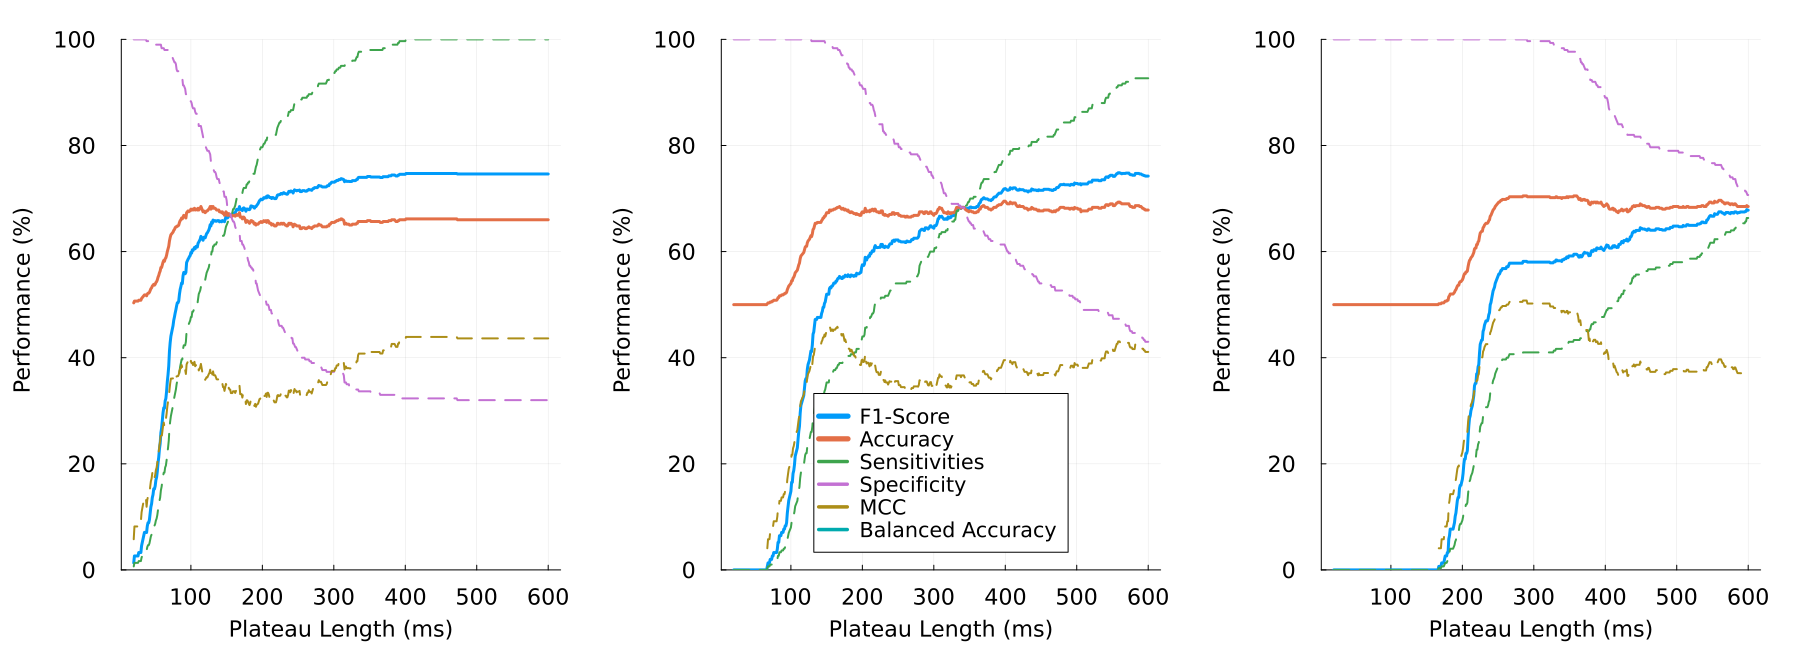

In [18]:
target = "E1"
distname= gaussian
sd = "25"

# UNBALANCED
experiment_filename = ""*target*"_UNBALANCED_PLOT_"*sd*""
performances = E1_unbalanced
plot1 = draw_special(performances[50],string(distname); balanced=false)
plot2 = draw_special(performances[100],string(distname); balanced=false)
plot3 = draw_special(performances[200],string(distname); balanced=false)
combined_plot = plot(plot1, plot2, plot3,  layout=(1,3), size=(1800, 650), margin=8mm) 

# EXTRA CONDITION 
experiment_filename = ""*target*"_EXTRA_PLOT_"*sd*""
performances= E1_extra
plot1 = draw_special(performances[50],string(distname))
plot2 = draw_special(performances[100],string(distname))
plot3 = draw_special(performances[200],string(distname))
combined_plot = plot(plot1, plot2, plot3,  layout=(1,3), size=(1800, 650), margin=8mm) 

# BALANCED
experiment_filename = ""*target*"_balanced_PLOT_"*sd*""
performances = E1_balanced
plot1 = draw_special(performances[50],string(distname))
plot2 = draw_special(performances[100],string(distname), legend=true)
plot3 = draw_special(performances[200],string(distname))
combined_plot = plot(plot1, plot2, plot3,  layout=(1,3), size=(1800, 650), margin=8mm) 

##### ROC CURVE

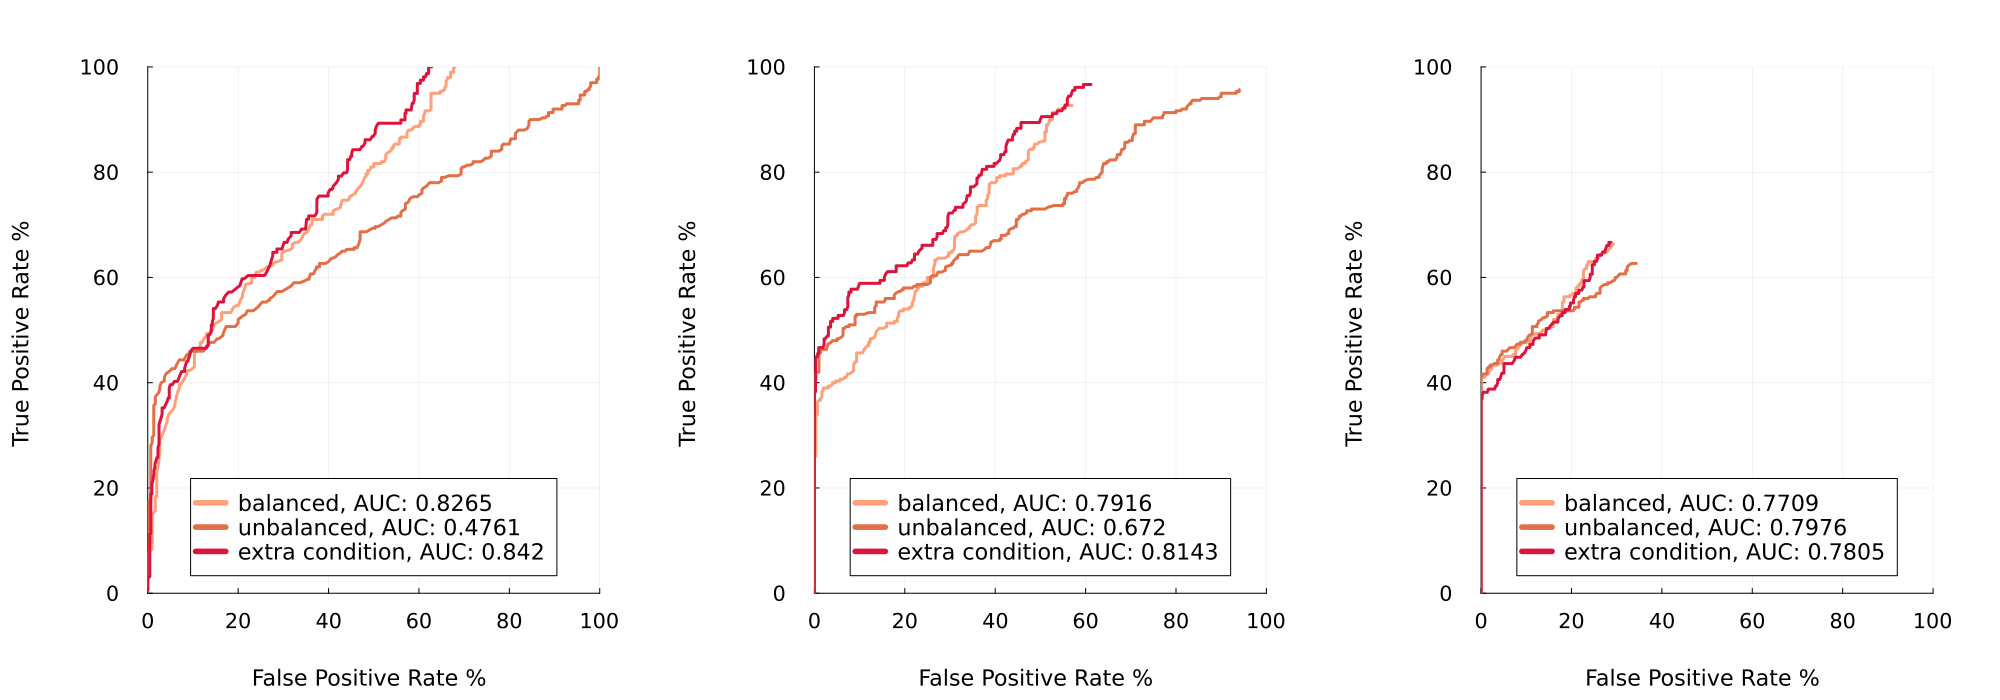

In [19]:
plot1 = draw_roc_special(E1_balanced[50], E1_extra[50], E1_unbalanced[50], string(distname))
plot2 = draw_roc_special(E1_balanced[100], E1_extra[100], E1_unbalanced[100], string(distname))
plot3 = draw_roc_special(E1_balanced[200], E1_extra[200], E1_unbalanced[200], string(distname))
ombined_plot = plot(plot1, plot2, plot3, layout=(1, 3), size=(2000, 700), margin=15mm)

##### Comparing MCC

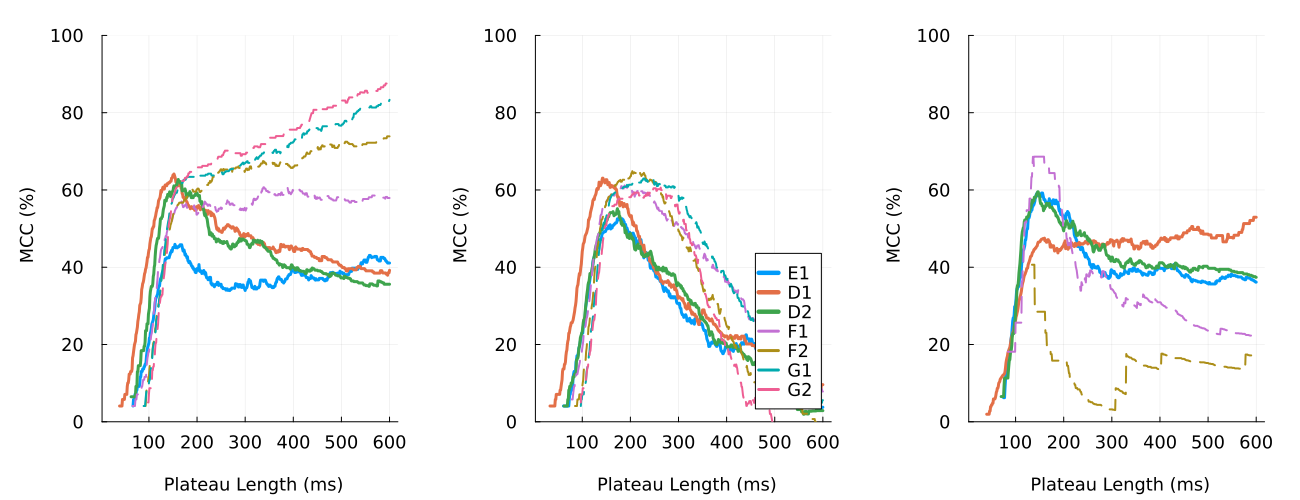

In [15]:
legend= :bottomright
distribution_args=(mean=100,)
p1 = plot(MCC_plot(E1_balanced[distribution_args.mean], D1_balanced[distribution_args.mean], D2_balanced[distribution_args.mean], F1_balanced[distribution_args.mean], F2_balanced[distribution_args.mean], G1_balanced[distribution_args.mean], G2_balanced[distribution_args.mean]), legend=:false) 
p2 = plot(MCC_plot(E1_extra[distribution_args.mean], D1_extra[distribution_args.mean], D2_extra[distribution_args.mean], F1_extra[distribution_args.mean], F2_extra[distribution_args.mean], G1_extra[distribution_args.mean], G2_extra[distribution_args.mean]), legend=legend)
p3 = plot(MCC_plot(E1_unbalanced[distribution_args.mean], D1_unbalanced[distribution_args.mean], D2_unbalanced[distribution_args.mean], F1_unbalanced[distribution_args.mean], F2_unbalanced[distribution_args.mean], G1_unbalanced[distribution_args.mean], G2_unbalanced[distribution_args.mean]), legend=:false) 
combined_plot = plot(p1, p2, p3, layout=(1,3), size=(1300, 500), margin=7mm )

##### Comparing Accuracy

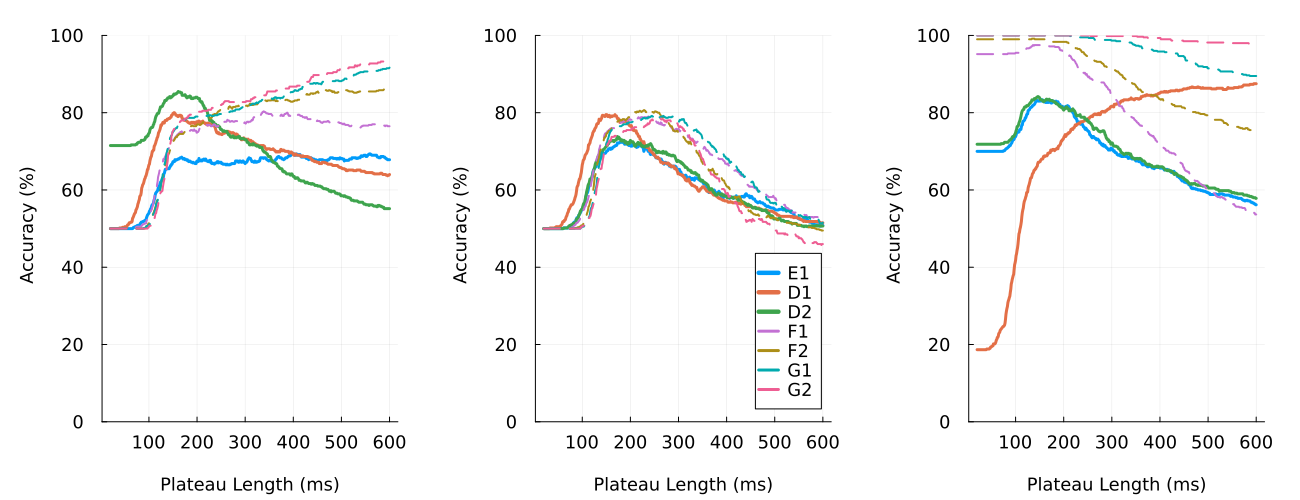

In [16]:
legend= :bottomright
distribution_args=(mean=100,)
p1 = plot(ACC_plot(E1_balanced[distribution_args.mean], D1_balanced[distribution_args.mean], D2_balanced[distribution_args.mean], F1_balanced[distribution_args.mean], F2_balanced[distribution_args.mean], G1_balanced[distribution_args.mean], G2_balanced[distribution_args.mean]), legend=:false) 
p2 = plot(ACC_plot(E1_extra[distribution_args.mean], D1_extra[distribution_args.mean], D2_extra[distribution_args.mean], F1_extra[distribution_args.mean], F2_extra[distribution_args.mean], G1_extra[distribution_args.mean], G2_extra[distribution_args.mean]), legend=legend)
p3 = plot(ACC_plot(E1_unbalanced[distribution_args.mean], D1_unbalanced[distribution_args.mean], D2_unbalanced[distribution_args.mean], F1_unbalanced[distribution_args.mean], F2_unbalanced[distribution_args.mean], G1_unbalanced[distribution_args.mean], G2_unbalanced[distribution_args.mean]), legend=:false) 
combined_plot = plot(p1, p2, p3, layout=(1,3), size=(1300, 500), margin=7mm )

##### Uniform distribution Experiment

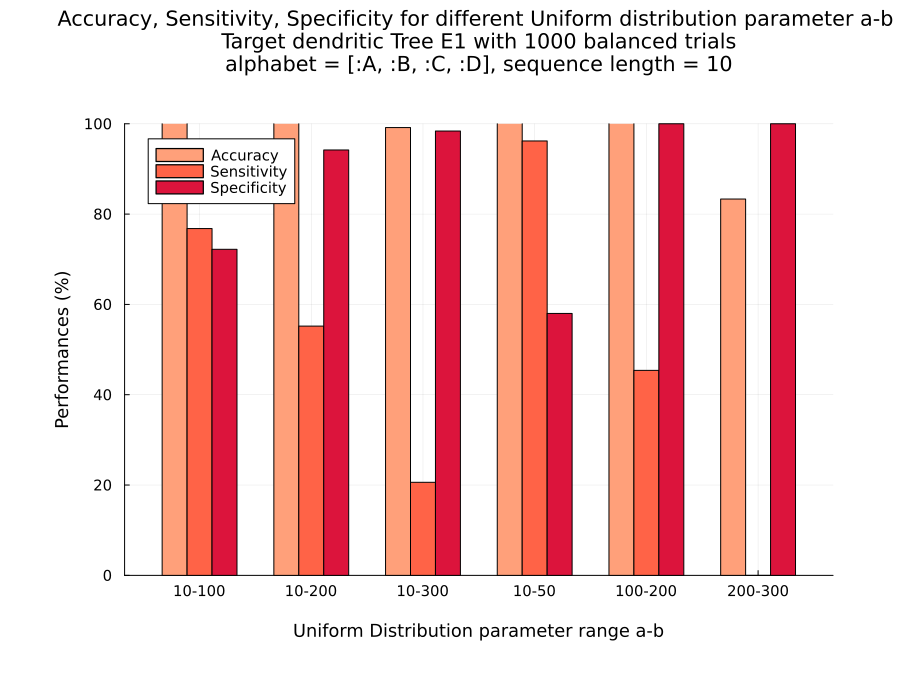

In [17]:
# LOAD UNIFORM DISTRIBUTION EXPERIMENT DATA
file_path = "D:/Bachelor_Thesis_Code/Performances/uniform_experiment/performances_uniform.jls"
experiment_filename = " E1 balanced"
draw_barplot(["target_E1_balanced_uniform_10_100", "target_E1_balanced_uniform_100_200", "target_E1_balanced_uniform_10_200", "target_E1_balanced_uniform_10_50", "target_E1_balanced_uniform_200_300", "target_E1_balanced_uniform_10_300" ])